In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torchvision.io import read_image
from glob import glob
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
import PIL
from PIL import Image

import numpy as np

# torch_model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')

img_size = 240
patch_size = 8

In [2]:
class DINODataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_names = glob(img_dir + '/*')
        self.transform = transform
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        with open(self.img_names[idx], 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img

In [3]:
transform = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset = DINODataset('data/', transform=transform)
dataloader = DataLoader(dataset)

In [4]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

## Load model with our own code

In [5]:
import vision_transformer as vits

vits.VERBOSE = True

model = vits.__dict__['vit_base'](patch_size=8, num_classes=0)

url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)

model.eval()
model.load_state_dict(state_dict)

Initialized VisionTransformer


<All keys matched successfully>

## Inference

init:
- embedding dimension (768)


1. Put input image of size `(B, nc, w, h)` to `model.forward`
2. Run PatchEmbed: run convolutional layer of kernel size `(patch_size, patch_size)` on input image, and get `embed_dim` out channels
3. We will get `img_size // patch_size * img_size // patch_size` output dimension along with `embed_dim`, because we will run equal length patch for each position in the image, with stride `patch_size`
4. Run through 


## Dino style masking

In [6]:
def shape_attention_to_grid(attn_raw):
    attn = attn_raw.detach().numpy().copy()
    nh = attn.shape[1]

    attn = attn[0, :, 0, 1:].reshape(nh, -1)
    attn = attn.reshape(nh, w_featmap, h_featmap)
    return attn

In [7]:
vits.VERBOSE = False

Run predictions on masked images

In [10]:
from copy import deepcopy

outputs = []
img_patch_size = 80 # Just drop the inputs from patches
# Compare to outputs of image without mask and with mask
# its much easier :DD
n_patches = img_size // img_patch_size
model.to(device)
model.eval()

w_featmap = img_size // patch_size
h_featmap = img_size // patch_size

for img in dataloader:
    # Cut patches out of image
    for patch_x in range(1, (n_patches + 1)):
        for patch_y in range(1, (n_patches + 1)):
            x_upper_bound = patch_x * img_patch_size
            y_upper_bound = patch_y * img_patch_size
        
            x_lower_bound = ((patch_x - 1) * img_patch_size)
            y_lower_bound = (patch_y - 1) * img_patch_size
            
            patched_img = deepcopy(img[:, :, 
                                x_lower_bound:x_upper_bound, 
                                y_lower_bound:y_upper_bound].squeeze(0))
            patched_img[:] = 0
            patched_img = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(patched_img)
            # Decide filling of background. Now its just 255
            # Maybe we could use something smarter like cutmix?
#             cropped_img = np.array(np.ones((img_size, img_size, 3)) * 255)
#             cropped_img = transform(Image.fromarray(np.uint8(cropped_img)))
            cropped_img = deepcopy(img)

            cropped_img[0, :, x_lower_bound:x_upper_bound, y_lower_bound:y_upper_bound] = deepcopy(patched_img)
            cropped_img = cropped_img.to(device)
            
            attn = model(cropped_img)
            # 1 x 12 x 901 x 901
            
            # Get mean
            attn_flat = attn.squeeze(0)
            
            outputs.append(attn_flat)
            



C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\torch\nn\functional.py:3455: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\torch\nn\functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


Run predictions on original image

In [11]:
orig_attn = model(img)

Stack the masked predictions to single tensor

In [12]:
torch_outs = torch.stack(outputs)

In [13]:
outs = torch.cat((orig_attn, torch_outs))

Get euclidean distance between original image and patched tensors

Take euclidean distance over the embedding dimensions

In [14]:
from torch.linalg import norm
norm_diff = norm(orig_attn - torch_outs, dim=2).detach().cpu()

Visualize each of the euclidean differences and maskings

In [125]:
from sklearn.cluster import SpectralClustering
cluster = SpectralClustering(2).fit(norm_diff)

C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [126]:
cluster.labels_

array([0, 0, 0, 0, 0, 0, 0, 1, 0])

In [16]:
norm_diff

torch.Size([9, 901])

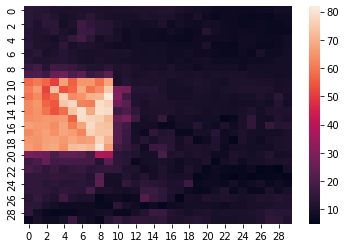

In [21]:
import seaborn as sns
# Drop CLS
reshaped_diff = norm_diff[:, 1:].reshape(-1, 30, 30)

sns.heatmap(reshaped_diff[3, :])

In [ ]:
reshaped_diff

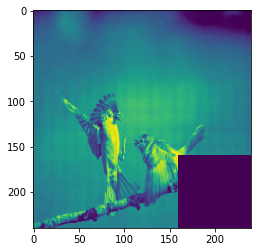

In [22]:
plt.imshow(cropped_img.squeeze(0)[2, :, :].detach())

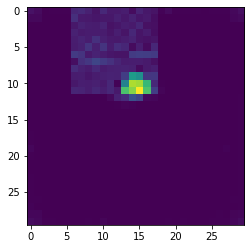

In [29]:
plt.imshow(torch_outs.mean(1)[1, :, :].cpu().detach())

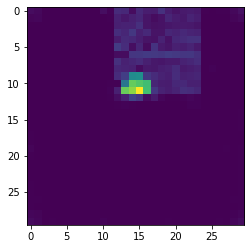

In [30]:
plt.imshow(torch_outs.mean(1)[2, :, :].cpu().detach())

## Plot attention maps

Get last attention layer

In [ ]:
vits.VERBOSE = False
attn_img_raw = model.get_last_selfattention(img)

Plot attention map averaged over different attention heads

In [69]:
attn_grid = shape_attention_to_grid(attn_img_raw)

We see stripes, which mean that some patch attends strongly to all patches? This is a little bit unclear, and can't be compared to CLS output, because I don't think these features are trained explicitly.

## Attention

We have <br>

**query** - query to find out which token is most relevant to our current one<br>
**key** - Key to match for the query. <br>
**value** - idk<br>



Take 8x8 patches, 1 patch goes to one input. You unroll it to 64 -> run through embedding layer -> input to transformer.

Transformers are permutation invariant, because they are basically MLP's with weight that is not fixed. We need to add positional encoding to make use of order. These positional encodings are learnable vectors, each vector has its own assigned 

The output dimension is 768, which translates to 12 attention heads of 8x8 patches. The attention heads are due to Multi-headed attention, which combines multiple attention key, query, value pairs and thus learns different representations on each attention head.

With multi-headed attention we also have on extra weight matrix. All of the output attention heads are concatenated, and we need to multiply it somehow to reduce dimensionality - we multiply is with the extra weight matrix.

In [6]:
w_featmap = img_size // patch_size
h_featmap = img_size // patch_size

I believe for attention we have 12 connections (heads), each for one patch. The output embeddings are of length 900 + 1 CLS. What is the other 900 dim?

In [7]:
attentions = model.get_last_selfattention(img)

NameError: name 'img' is not defined

In [10]:
attn_grid = shape_attention_to_grid(attentions)

NameError: name 'attentions' is not defined

Get how much tokens attend to CLS token, and exclude CLS token itself

In [146]:
attentions[0, :, 0, 1:].reshape(nh, -1).shape

torch.Size([12, 900])

In [149]:
attentions_shaped.reshape(nh, w_featmap, h_featmap).shape

torch.Size([12, 30, 30])

In [148]:
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions_shaped = attentions[0, :, 0, 1:].reshape(nh, -1)

In [130]:
# Shape from 12,900 to 12,30,30
attentions_shaped = attentions_shaped.reshape(nh, w_featmap, h_featmap)

# Interpolate from 30x30 to 240x240 or something
attentions_shaped = torch.nn.functional.interpolate(attentions_shaped.unsqueeze(0), 
                                              scale_factor=patch_size, 
                                              mode="nearest")[0].cpu().detach().numpy()


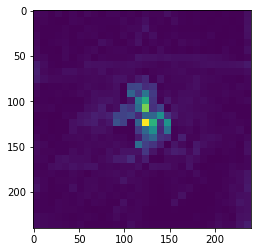

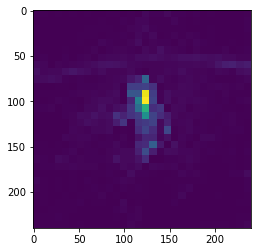

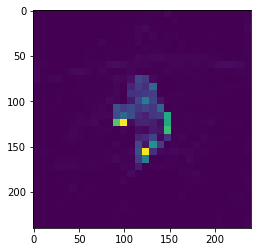

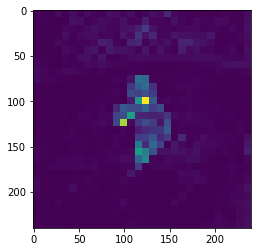

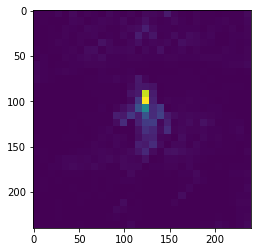

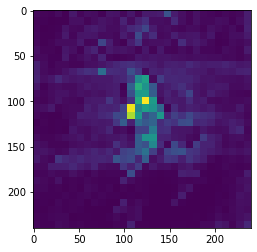

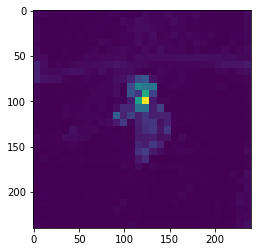

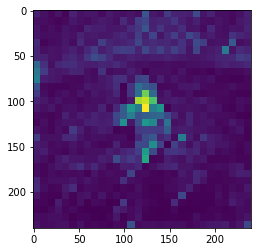

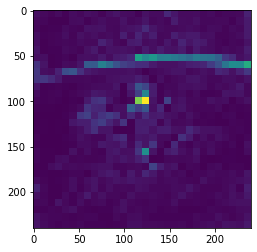

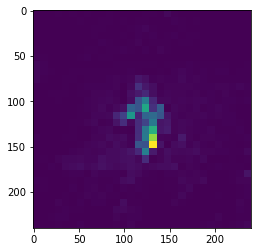

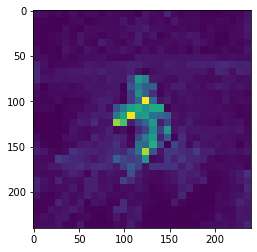

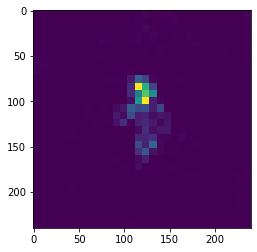

In [142]:
for atn in attentions_shaped:
    plt.figure()
    plt.imshow(atn)

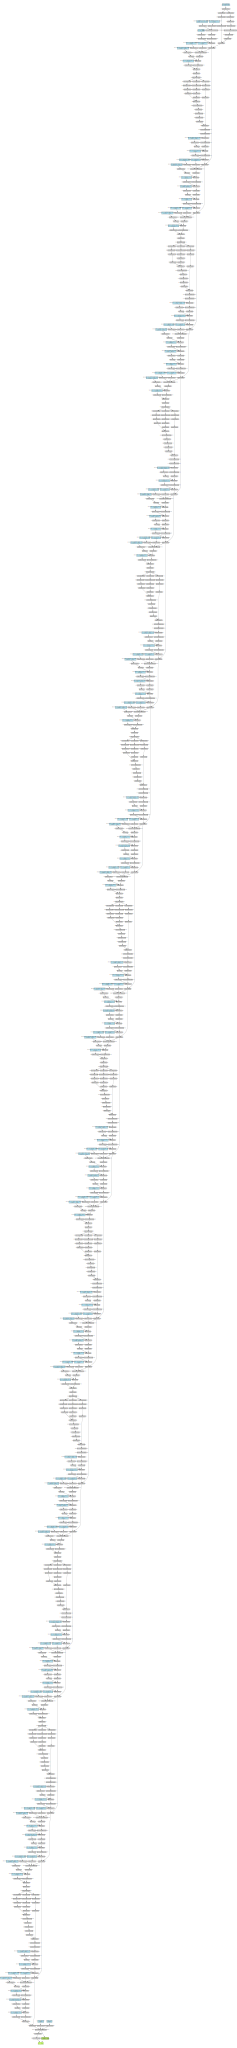

In [4]:
from torchviz import make_dot

make_dot(out, params=dict(vitb8.named_parameters()))